<a href="https://colab.research.google.com/github/khanhkhanhlele/ML-lab/blob/main/session_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tìm hiểu về tensorflow

###Basics

In [ ]:
import tensorflow as tf
import numpy as np
#import tensorflow

giống np.array tf tạo ra các array nhiều chiều gọi là các tensor

In [ ]:
x = tf.constant([[1., 2., 3.],
                 [4., 5., 6.]])

print(x)
print(x.shape)
print(x.dtype)

tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]], shape=(2, 3), dtype=float32)
(2, 3)
<dtype: 'float32'>


các phép toán cơ bản

In [ ]:
print(x + x)
print("------------------")
print(5 * x)
print("------------------")
print(x @ tf.transpose(x))
print("------------------")
print(tf.concat([x, x, x], axis=0))
print("------------------")
print(tf.nn.softmax(x, axis=-1)) #hàm softmax
print("------------------")
print(tf.reduce_sum(x)) #tổng các phần tử


tf.Tensor(
[[ 2.  4.  6.]
 [ 8. 10. 12.]], shape=(2, 3), dtype=float32)
------------------
tf.Tensor(
[[ 5. 10. 15.]
 [20. 25. 30.]], shape=(2, 3), dtype=float32)
------------------
tf.Tensor(
[[14. 32.]
 [32. 77.]], shape=(2, 2), dtype=float32)
------------------
tf.Tensor(
[[1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]
 [1. 2. 3.]
 [4. 5. 6.]], shape=(6, 3), dtype=float32)
------------------
tf.Tensor(
[[0.09003057 0.24472848 0.66524094]
 [0.09003057 0.24472848 0.66524094]], shape=(2, 3), dtype=float32)
------------------
tf.Tensor(21.0, shape=(), dtype=float32)


Variables

tf.Tensor là cố định, sử dụng tf.Variable làm biến

In [ ]:
var = tf.Variable([0.0, 0.0, 0.0])
var.assign([1, 2, 3])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([1., 2., 3.], dtype=float32)>

In [ ]:
var.assign_add([1, 1, 1])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([2., 3., 4.], dtype=float32)>

tính đạo hàm 

In [ ]:
x = tf.Variable(1.0)

def f(x):
  y = x**2 + 2*x - 5
  return y
f(x) 

<tf.Tensor: shape=(), dtype=float32, numpy=-2.0>

In [ ]:
with tf.GradientTape() as tape:
  y = f(x)

g_x = tape.gradient(y, x)  # g(x) = dy/dx

g_x

<tf.Tensor: shape=(), dtype=float32, numpy=4.0>

##Multi-layer Perceptron và Backpropagation


ý tưởng cơ bản của phương pháp mạng neuron là gồm lan truyền tiến và lan truyền ngược, lan truyền tiến thì tính giá trị thông qua weight và hàm kích hoạt, lan truyền ngược thì thì đạo hàm để điều chỉnh hệ số w, ở đây sử dụng tính chất đạo hàm của hàm hợp.

Code được dựa theo [bài sau đây](https://machinelearningcoban.com/2017/02/24/mlp/)

###code lại từ đầu

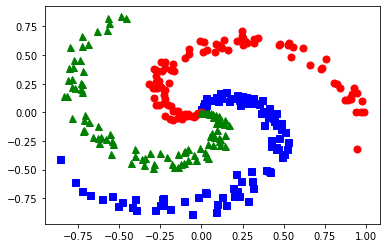

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

N = 100 # number of points per class
d0 = 2 # dimensionality
C = 3 # number of classes
X = np.zeros((d0, N*C)) # data matrix (each row = single example)     #ma trận 0 shape 2, 300
y = np.zeros(N*C, dtype='uint8') # class labels     #ma trận 0 shape 300

for j in range(C):
  ix = range(N*j,N*(j+1))     #ix = [0,1,...,99]
  r = np.linspace(0.0,1,N) # radius  #r = [1, 1,(01), ... 1] có 100 số
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta #t = 100 số từ 0 đến 4 + 100 số random theo pp chuẩn tắc * 0.2
  X[:,ix] = np.c_[r*np.sin(t), r*np.cos(t)].T  #tọa độ từng điểm trên hình tròn... np.sin và np.cos nhân với r để rút gọn 
  y[ix] = j # nhãn của điểm ix tương ứng

plt.plot(X[0, :N], X[1, :N], 'bs', markersize = 7);
plt.plot(X[0, N:2*N], X[1, N:2*N], 'ro', markersize = 7);
plt.plot(X[0, 2*N:], X[1, 2*N:], 'g^', markersize = 7);
#vẽ 
plt.show()


nhiệm vụ sẽ phân loại các điểm dữ liệu trên hình

In [ ]:
def softmax(V):
    e_V = np.exp(V - np.max(V, axis = 0, keepdims = True))
    Z = e_V / e_V.sum(axis = 0)
    return Z
#  hàm softmax

## One-hot coding
from scipy import sparse
def convert_labels(y, C = 3):
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y
# thay vì sử dụng nhãn của từng điểm X là 1,2,3 thì ta coi đây là classification 
# biến các nhãn của X thành [1, 0, 0] [0, 1, 0] [0, 0, 1]

# cost or loss function
def cost(Y, Yhat):
    return -np.sum(Y*np.log(Yhat))/Y.shape[1]
# hàm mất mát bằng 1/N nhân tổng y. ln(y dự đoán)

In [ ]:
d0 = 2 #lớp input có 2 chiều là x và y
d1 = h = 200 # size of hidden layer 
d2 = C = 3 #lớp output là 3 phân loại vào 3 nhóm

# initialize parameters randomely 
W1 = 0.01*np.random.randn(d0, d1)
b1 = np.zeros((d1, 1))
W2 = 0.01*np.random.randn(d1, d2)
b2 = np.zeros((d2, 1))
#khởi tạo các weight và bias cho mạng neron với w1 đc khởi tạo random và b bằng 0

# X = X.T # each column of X is a data point 
Y = convert_labels(y, C) #one hot coding Y
N = X.shape[1] #100
eta = 1 # learning rate 

for i in range(10000):
    ## Feedforward 
    ## Lan truyền tiến
    Z1 = np.dot(W1.T, X) + b1 # input layer to hidden layer
    A1 = np.maximum(Z1, 0)  #dùng hàm ReLu
    Z2 = np.dot(W2.T, A1) + b2 #hidden layer to output layer
    Yhat = softmax(Z2) # dùng hàm softmax
    
    # compute the loss: average cross-entropy loss
    loss = cost(Y, Yhat)
    # hàm vi phí
    
    # print loss after each 1000 iterations
    if i %1000 == 0: 
        print("iter %d, loss: %f" %(i, loss))
    
    # backpropagation
    # lan truyền ngược
    E2 = (Yhat - Y )/N
    dW2 = np.dot(A1, E2.T)
    db2 = np.sum(E2, axis = 1, keepdims = True)
    E1 = np.dot(W2, E2)
    E1[Z1 <= 0] = 0 # gradient of ReLU 
    dW1 = np.dot(X, E1.T)
    db1 = np.sum(E1, axis = 1, keepdims = True)
    # tính đạo hàm theo hàm biến w và b

    # Gradient Descent update 
    # import pdb; pdb.set_trace()  # breakpoint 47741f63 //
    W1 += -eta*dW1 
    b1 += -eta*db1 
    W2 += -eta*dW2
    b2 += -eta*db2 
    # cập nhật giá trị W, b

iter 0, loss: 1.098584
iter 1000, loss: 0.149687
iter 2000, loss: 0.059400
iter 3000, loss: 0.037443
iter 4000, loss: 0.029717
iter 5000, loss: 0.025769
iter 6000, loss: 0.023220
iter 7000, loss: 0.021425
iter 8000, loss: 0.020135
iter 9000, loss: 0.019144


sau khi giảm hàm mất mát sau 10000 vòng lặp ta đã tìm đc các weight và bias thích hợp bây giờ test lại chính trên bộ dữ liệu ban đầu kiểm tra độ chính xác

In [ ]:
Z1 = np.dot(W1.T, X) + b1 
A1 = np.maximum(Z1, 0)
Z2 = np.dot(W2.T, A1) + b2
predicted_class = np.argmax(Z2, axis=0)
acc = (100*np.mean(predicted_class == y))
print('training accuracy: %.2f %%' % acc)

training accuracy: 99.33 %


###dùng thư viện [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

In [ ]:
from sklearn.neural_network import MLPClassifier

In [ ]:
print(X.shape)
print(Y.shape)
#không biết sao training vs X Y không được nhưng lại được vs X.T, Y.T
X = X.T
Y = Y.T

(2, 300)
(3, 300)


In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100), max_iter=10000)
# cho 10000 vòng lặp, các thông số khác giống defaut của hàm MLPClassifier
# riêng có learning rate là 0.001 chứ không phải là 1 như code tay ở trên
clf.fit(X,Y)
y_pred = clf.predict(X)
acc = (100*np.mean(y_pred == Y))
print('training accuracy: %.2f %%' % acc)

training accuracy: 99.00 %


### dùng tensorflow

In [ ]:
print(X.shape)
print(Y.shape)
print(y.shape)

(300, 2)
(300, 3)
(300,)


In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([tf.keras.layers.Flatten(), 
                                    tf.keras.layers.Dense(100, activation=tf.nn.relu), 
                                    tf.keras.layers.Dense(3, activation=tf.nn.softmax)])
model.compile(optimizer = tf.keras.optimizers.Adam(),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(X, y, epochs=1000)
y_pred = model.predict(X)
acc = (100*np.mean(y_pred == y))
print('training accuracy: %.2f %%' % acc)

Epoch 1/1000
10/10 [==============================] - 1s 5ms/step - loss: 1.0725 - accuracy: 0.4600
Epoch 2/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0381 - accuracy: 0.5233
Epoch 3/1000
10/10 [==============================] - 0s 4ms/step - loss: 1.0062 - accuracy: 0.5433
Epoch 4/1000
10/10 [==============================] - 0s 8ms/step - loss: 0.9774 - accuracy: 0.5500
Epoch 5/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.9495 - accuracy: 0.5567
Epoch 6/1000
10/10 [==============================] - 0s 7ms/step - loss: 0.9234 - accuracy: 0.5567
Epoch 7/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.8981 - accuracy: 0.5500
Epoch 8/1000
10/10 [==============================] - 0s 3ms/step - loss: 0.8751 - accuracy: 0.5500
Epoch 9/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.8521 - accuracy: 0.5567
Epoch 10/1000
10/10 [==============================] - 0s 5ms/step - loss: 0.8318 - accuracy: 0.5767

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


ở đây accuracy của model là 0.9933 nhưng tính ra lại được 0.00% vì ...

In [ ]:
model.evaluate(X,y)

10/10 [==============================] - 0s 2ms/step - loss: 0.0205 - accuracy: 0.9933


[0.020461976528167725, 0.9933333396911621]

chưa hiểu tại sao acc là 0.9933 mà predict không đc :((